# Modeling likelihood responses

In [1]:
import sumProduct as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

In [2]:
data=np.genfromtxt('PI-ANNA_DatenN=36CSV.csv', delimiter=";",skip_header=2,dtype=str)
type(data[1,1])

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i,j]=str(data[i,j]).replace(",",".")
        
data_sens_pain=data[:,5:8].astype('float')
data_sens_nopain=data[:,8:11].astype('float')

In [3]:
data_sens_pain[:,1]

array([  9.,   6.,   0.,  67.,   3.,  15.,  12.,  14.,   7.,   0.,  49.,
         0.,   0.,   0.,   1.,  70.,   0.,   2.,  66.,  10.,  82.,  30.,
         0.,   0.,   0.,  12.,  60.,  15.,   0.,   0.,  20., 100.,  36.,
         0.,  75.])

C:\Users\OEM\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


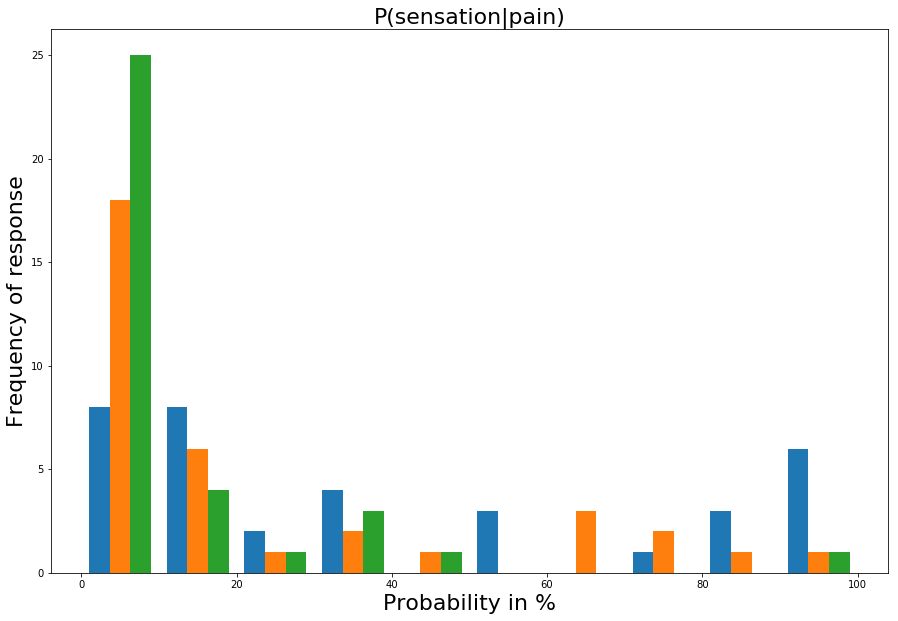

In [4]:
data_sens_pain
plt.figure(figsize=(15.0,10.0))
plt.title('P(sensation|pain)',fontsize=22)
plt.xlabel('Probability in %',fontsize=22)
plt.ylabel('Frequency of response',fontsize=22)
plt.hist(data_sens_pain)
plt.legend(fontsize=14)
plt.show()

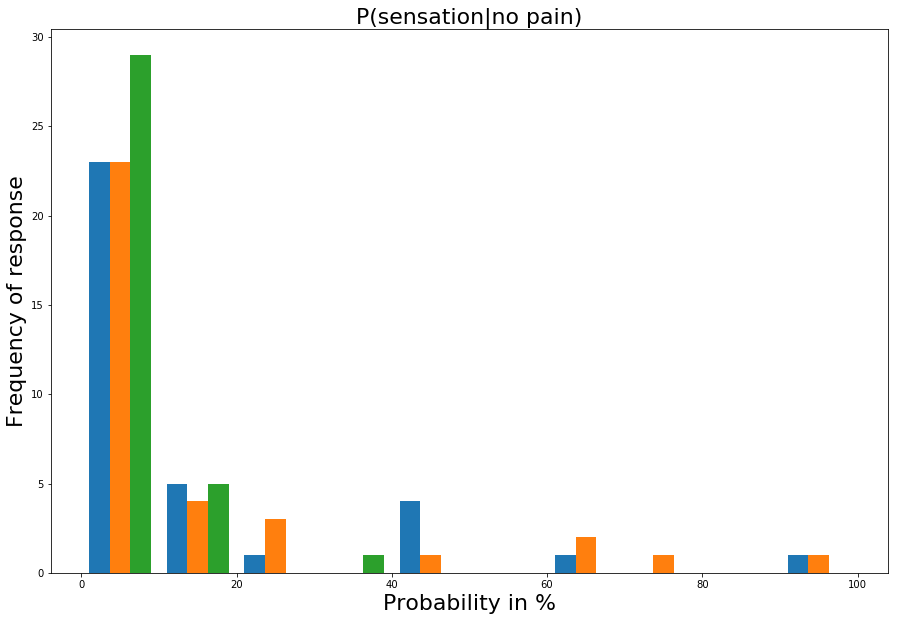

In [5]:
plt.figure(figsize=(15.0,10.0))
plt.title('P(sensation|no pain)',fontsize=22)
plt.xlabel('Probability in %',fontsize=22)
plt.ylabel('Frequency of response',fontsize=22)
plt.hist(data_sens_nopain)
plt.show()

In [5]:
# 3 Kategorien von sens|pain, <30, 30-64, >64
x=data_sens_pain
A=(x<30).astype('float')*15 + (x>64).astype('float')*75
A[A < .1] = 50

In [6]:
y=data_sens_nopain
B=(y<30).astype('float')*15 + (y>64).astype('float')*75
B[B < .1] = 50

In [7]:
allvpdata_senspain=[]
for vp in A: 
    senspain_values=[]
    for v in vp: 
        if v==75.:
            senspain_values.append('yes')
        elif v==50.:
            senspain_values.append('maybe')
        elif v==15.:
            senspain_values.append('no')
    allvpdata_senspain.append(senspain_values)

In [8]:
allvpdata_sensnopain=[]
for vp in B: 
    sensnopain_values=[]
    for v in vp: 
        if v==75.:
            sensnopain_values.append('yes')
        elif v==50.:
            sensnopain_values.append('maybe')
        elif v==15.:
            sensnopain_values.append('no')
    allvpdata_sensnopain.append(sensnopain_values)

In [9]:
sick_senspain=[]
control_senspain=[]
for vp in allvpdata_senspain[0:15]:
    sick_senspain.append(vp)
for vp in allvpdata_senspain[16:35]:
    control_senspain.append(vp)

In [10]:
sick_sensnopain=[]
control_sensnopain=[]
for vp in allvpdata_sensnopain[0:15]:
    sick_sensnopain.append(vp)
for vp in allvpdata_sensnopain[16:35]:
    control_sensnopain.append(vp)

In [24]:
belly_nopain=[]
neck_nopain=[]
hand_nopain=[]
for vp in allvpdata_sensnopain:
    belly_nopain.append(vp[0])
for vp in allvpdata_sensnopain:
    neck_nopain.append(vp[1])
for vp in allvpdata_sensnopain:
    hand_nopain.append(vp[2])

sickbelly_nopain=belly_nopain[0:15]
sickneck_nopain=neck_nopain[0:15]
sickhand_nopain=hand_nopain[0:15]

healthybelly_nopain=belly_nopain[15:]
healthyneck_nopain=neck_nopain[15:]
healthyhand_nopain=hand_nopain[15:]

# -----------------------------------------------------------------

# Basic Model

In [11]:
def buildbasicmodel():
    s=sp.variableNode(name='S1', vrange=['yes','maybe','no'])
    variable=[s]
    u=sp.freeEnergyFactorNode()
    u.addNeighbour(s)
    factor=[u]
    
    def basicprior(condrv,conditioners):
        if condrv[0] is None:
            return 10.0
        if condrv[0]=='yes':
            return 0.3333
        if condrv[0]=='maybe':
            return 0.333
        if condrv[0]=='no':
            return 0.333
    u.setPrior(basicprior)
    allNodes=[s,u]
    
    return(allNodes,variable,factor)

In [12]:
def basicmodelEvidence(equal_model=False,individual_model=False,sick=False,healthy=False,alldata=False,pain=False,nopain=False):
    
    modelEvidence=0.0
    
    if equal_model==True:
        if sick==True:
            allNodes,variable,factor=buildbasicmodel()
            sp.startLearning(allNodes)
            if pain==True:
                for vp in sick_senspain:
                    for v in vp:
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factor[0].KLDiv_post_prior
            if nopain==True:
                for vp in sick_sensnopain:
                    for v in vp:
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factor[0].KLDiv_post_prior
                    
            
            
        if healthy==True:
            allNodes,variable,factor=buildbasicmodel()
            sp.startLearning(allNodes)
            if pain==True:
                for vp in control_senspain:
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factor[0].KLDiv_post_prior
            if nopain==True:
                for vp in control_sensnopain:
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factor[0].KLDiv_post_prior
                    
            
            
        if alldata==True: 
            allNodes,variable,factor=buildbasicmodel()
            sp.startLearning(allNodes)
            if pain==True:
                for vp in allvpdata_senspain:
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factor[0].KLDiv_post_prior
            if nopain==True:
                for vp in allvpdata_sensnopain:
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factor[0].KLDiv_post_prior
                
            
            
    if individual_model==True:
        
        if sick==True:
            if pain==True:
                for vp in sick_senspain:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
            if nopain==True:
                for vp in sick_sensnopain:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                    
                
        if healthy==True:
            if pain==True:
                for vp in control_senspain:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
            if nopain==True:
                for vp in control_sensnopain:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                    
                
        if alldata==True:
            if pain==True:
                for vp in allvpdata_senspain:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
            if nopain==True:
                for vp in allvpdata_sensnopain:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for v in vp: 
                        variable[0].observe(v)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        modelEvidence+=logp
                        sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                
                
            
            
    return(modelEvidence)
                

In [13]:
EviBasicSickPain_equal=basicmodelEvidence(equal_model=True,sick=True,pain=True)
EviBasicHealthyPain_equal=basicmodelEvidence(equal_model=True,healthy=True,pain=True)
EviBasicAllPain_equal=basicmodelEvidence(equal_model=True,alldata=True,pain=True)

EviBasicSickPain_individual=basicmodelEvidence(individual_model=True,sick=True,pain=True)
EviBasicHealthyPain_individual=basicmodelEvidence(individual_model=True, healthy=True,pain=True)
EviBasicAllPain_individual=basicmodelEvidence(individual_model=True, alldata=True,pain=True)

EviBasicSickNoPain_equal=basicmodelEvidence(equal_model=True,sick=True,nopain=True)
EviBasicHealthyNoPain_equal=basicmodelEvidence(equal_model=True,healthy=True,nopain=True)
EviBasicAllNoPain_equal=basicmodelEvidence(equal_model=True,alldata=True,nopain=True)

EviBasicSickNoPain_individual=basicmodelEvidence(individual_model=True,sick=True,nopain=True)
EviBasicHealthyNoPain_individual=basicmodelEvidence(individual_model=True, healthy=True,nopain=True)
EviBasicAllNoPain_individual=basicmodelEvidence(individual_model=True, alldata=True,nopain=True)

starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-produ

In [14]:
AllBasic=[EviBasicSickPain_equal,
EviBasicHealthyPain_equal,
EviBasicAllPain_equal,
EviBasicSickPain_individual,
EviBasicHealthyPain_individual,
EviBasicAllPain_individual,
EviBasicSickNoPain_equal,
EviBasicHealthyNoPain_equal,
EviBasicAllNoPain_equal,
EviBasicSickNoPain_individual,
EviBasicHealthyNoPain_individual,
EviBasicAllNoPain_individual]

In [15]:
sum(AllBasic)

Pd_m_basic=[]
posterior_basic=[]
for a in AllBasic:
    Pd_m_basic+=[np.exp(a)*(1/len(AllBasic))]
P_d_basic=sum(Pd_m_basic)

for d in Pd_m_basic:
    posterior_basic.append(d/P_d_basic)
posterior_basic

print(sum(posterior_basic))

1.0000000000000002


# ---------------------------------------------------------------
# Basic Model 2: sensation specific models

In [16]:
belly_pain=[]
neck_pain=[]
hand_pain=[]
for vp in allvpdata_senspain:
    belly_pain.append(vp[0])
for vp in allvpdata_senspain:
    neck_pain.append(vp[1])
for vp in allvpdata_senspain:
    hand_pain.append(vp[2])

sickbelly_pain=belly_pain[0:15]
sickneck_pain=neck_pain[0:15]
sickhand_pain=hand_pain[0:15]

healthybelly_pain=belly_pain[15:]
healthyneck_pain=neck_pain[15:]
healthyhand_pain=hand_pain[15:]

In [25]:
def basicspecmodelEvidence(pain=False,nopain=False,equal_model=False,individualmodel=False,sick=False,healthy=False,alldata=False,belly=False,neck=False,hand=False):
    
    modelEvidence=0.0
    
    if pain==True:
        
        if equal_model==True:
            if sick==True: 
                if belly==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for b in sickbelly_pain:
                        variable[0].observe(b)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior  
                if neck==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for n in sickneck_pain:
                        variable[0].observe(n)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for h in sickhand_pain:
                        variable[0].observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior

            if healthy==True:
                if belly==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for b in healthybelly_pain:
                        variable[0].observe(b)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if neck==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for n in healthyneck_pain:
                        variable[0].observe(n)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for h in healthyhand_pain:
                        variable[0].observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior

            if alldata==True:
                if belly==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for b in belly_pain:
                        variable[0].observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if neck==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for n in neck_pain:
                        variable[0].observe(n)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for h in hand_pain:
                        variable[0].observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior

        if individualmodel==True:
            if sick==True:
                if belly==True:
                    for b in sickbelly_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(b)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior

                if neck==True:
                    for n in sickneck_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(n)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    for h in sickhand_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(h)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
            if healthy==True:
                if belly==True:
                    for b in healthybelly_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(b)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if neck==True:
                    for n in healthyneck_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(n)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    for h in healthyhand_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(h)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
            if alldata==True:
                if belly==True:
                    for b in belly_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(b)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if neck==True:
                    for n in neck_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(n)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    for h in hand_pain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(h)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                        
    if nopain==True:
        if equal_model==True:
            if sick==True: 
                if belly==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for b in sickbelly_nopain:
                        variable[0].observe(b)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior  
                if neck==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for n in sickneck_nopain:
                        variable[0].observe(n)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for h in sickhand_nopain:
                        variable[0].observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior

            if healthy==True:
                if belly==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for b in healthybelly_nopain:
                        variable[0].observe(b)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if neck==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for n in healthyneck_nopain:
                        variable[0].observe(n)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for h in healthyhand_nopain:
                        variable[0].observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior

            if alldata==True:
                if belly==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for b in belly_nopain:
                        variable[0].observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if neck==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for n in neck_nopain:
                        variable[0].observe(n)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    allNodes,variable,factor=buildbasicmodel()
                    sp.startLearning(allNodes)
                    for h in hand_nopain:
                        variable[0].observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(variable[0].marginal()[-1])
                    logp+=modelEvidence
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factor[0].KLDiv_post_prior

        if individualmodel==True:
            if sick==True:
                if belly==True:
                    for b in sickbelly_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(b)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior

                if neck==True:
                    for n in sickneck_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(n)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    for h in sickhand_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(h)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
            if healthy==True:
                if belly==True:
                    for b in healthybelly_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(b)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if neck==True:
                    for n in healthyneck_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(n)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    for h in healthyhand_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(h)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
            if alldata==True:
                if belly==True:
                    for b in belly_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(b)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if neck==True:
                    for n in neck_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(n)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
                if hand==True:
                    for h in hand_nopain:
                        allNodes,variable,factor=buildbasicmodel()
                        sp.startLearning(allNodes)
                        variable[0].observe(h)
                        sp.runSumProduct(allNodes)
                        logp=np.log(variable[0].marginal()[-1])
                        logp+=modelEvidence
                        sp.accumulateEvidence(allNodes)
                        sp.learn(allNodes)
                        modelEvidence+=factor[0].KLDiv_post_prior
            

    return(modelEvidence)




In [26]:
# P(SENSATION|PAIN)
EviBasicSickBelly_equal=basicspecmodelEvidence(pain=True,equal_model=True, sick=True, belly=True)
EviBasicSickNeck_equal=basicspecmodelEvidence(pain=True,equal_model=True,sick=True,neck=True)
EviBasicSickHand_equal=basicspecmodelEvidence(pain=True,equal_model=True,sick=True,hand=True)

EviBasicHealthyBelly_equal=basicspecmodelEvidence(pain=True,equal_model=True,healthy=True,belly=True)
EviBasicHealthyNeck_equal=basicspecmodelEvidence(pain=True,equal_model=True,healthy=True,neck=True)
EviBasicHealthyHand_equal=basicspecmodelEvidence(pain=True,equal_model=True,healthy=True,hand=True)

EviBasicSickBelly_individual=basicspecmodelEvidence(pain=True, individualmodel=True,sick=True,belly=True)
EviBasicSickNeck_individual=basicspecmodelEvidence(pain=True, individualmodel=True,sick=True,neck=True)
EviBasicSickHand_individual=basicspecmodelEvidence(pain=True,individualmodel=True,sick=True,hand=True)

EviBasicHealthyBelly_individual=basicspecmodelEvidence(pain=True,individualmodel=True,healthy=True,belly=True)
EviBasicHealthyNeck_individual=basicspecmodelEvidence(pain=True,individualmodel=True,healthy=True,neck=True)
EviBasicHealthyHand_individual=basicspecmodelEvidence(pain=True,individualmodel=True,healthy=True,hand=True)

starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating ev

In [27]:
EviBasicSickBellyNOpain_equal=basicspecmodelEvidence(nopain=True,equal_model=True, sick=True, belly=True)
EviBasicSickNeckNOpain_equal=basicspecmodelEvidence(nopain=True,equal_model=True,sick=True,neck=True)
EviBasicSickHandNOpain_equal=basicspecmodelEvidence(nopain=True,equal_model=True,sick=True,hand=True)

EviBasicHealthyBellyNOpain_equal=basicspecmodelEvidence(nopain=True,equal_model=True,healthy=True,belly=True)
EviBasicHealthyNeckNOpain_equal=basicspecmodelEvidence(nopain=True,equal_model=True,healthy=True,neck=True)
EviBasicHealthyHandNOpain_equal=basicspecmodelEvidence(nopain=True,equal_model=True,healthy=True,hand=True)

EviBasicSickBellyNOpain_individual=basicspecmodelEvidence(nopain=True, individualmodel=True,sick=True,belly=True)
EviBasicSickNeckNOpain_individual=basicspecmodelEvidence(nopain=True, individualmodel=True,sick=True,neck=True)
EviBasicSickHandNOpain_individual=basicspecmodelEvidence(nopain=True,individualmodel=True,sick=True,hand=True)

EviBasicHealthyBellyNOpain_individual=basicspecmodelEvidence(nopain=True,individualmodel=True,healthy=True,belly=True)
EviBasicHealthyNeckNOpain_individual=basicspecmodelEvidence(nopain=True,individualmodel=True,healthy=True,neck=True)
EviBasicHealthyHandNOpain_individual=basicspecmodelEvidence(nopain=True,individualmodel=True,healthy=True,hand=True)

starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating ev

In [28]:
AllBasicSpecPain=[EviBasicSickBelly_equal,
EviBasicSickNeck_equal,
EviBasicSickHand_equal,
EviBasicHealthyBelly_equal,
EviBasicHealthyNeck_equal,
EviBasicHealthyHand_equal,
EviBasicSickBelly_individual,
EviBasicSickNeck_individual,
EviBasicSickHand_individual,
EviBasicHealthyBelly_individual,
EviBasicHealthyNeck_individual,
EviBasicHealthyHand_individual]

In [31]:
AllBasicSpecNoPain=[EviBasicSickBellyNOpain_equal,
EviBasicSickNeckNOpain_equal,
EviBasicSickHandNOpain_equal,
EviBasicHealthyBellyNOpain_equal,
EviBasicHealthyNeckNOpain_equal,
EviBasicHealthyHandNOpain_equal,
EviBasicSickBellyNOpain_individual,
EviBasicSickNeckNOpain_individual,
EviBasicSickHandNOpain_individual,
EviBasicHealthyBellyNOpain_individual,
EviBasicHealthyNeckNOpain_individual,
EviBasicHealthyHandNOpain_individual]

In [41]:
Pd_m_basicspec=[]
posterior_basicspec=[]

for a in AllBasicSpecNoPain:
    Pd_m_basicspec+=[np.exp(a)*1/len(AllBasicSpec)]
P_d_basicspec=sum(Pd_m_basicspec)

for c in Pd_m_basicspec:
    posterior_basicspec.append(c/P_d_basicspec)
print(posterior_basicspec)
print(sum(posterior_basicspec))

[0.07995613315497498, 0.07995613315497498, 0.07995613315497498, 0.07995613315497498, 0.07995613315497498, 0.07995613315497498, 0.08564612488727572, 0.08564612488727572, 0.08564612488727572, 0.08777494213610762, 0.08777494213610762, 0.08777494213610762]
0.9999999999999998


In [40]:
Pd_m_basicspecnopain=[]
posterior_basicspecnopain=[]

for i in AllBasicSpecNoPain:
    Pd_m_basicspecnopain+=[np.exp(i)*1/len(AllBasicSpecNoPain)]
P_d_basicspecnopain=sum(Pd_m_basicspecnopain)

for p in Pd_m_basicspecnopain:
    posterior_basicspecnopain.append(p/P_d_basicspecnopain)
print(posterior_basicspecnopain)
print(sum(posterior_basicspecnopain))

[0.07995613315497498, 0.07995613315497498, 0.07995613315497498, 0.07995613315497498, 0.07995613315497498, 0.07995613315497498, 0.08564612488727572, 0.08564612488727572, 0.08564612488727572, 0.08777494213610762, 0.08777494213610762, 0.08777494213610762]
0.9999999999999998


# ------------------------------------------------------------------
# Hierarchical Model #

In [36]:
def buildhierarchicalmodel():
    belly=sp.variableNode(name='bauch', vrange=['yes','maybe','no'])
    neck=sp.variableNode(name='neck', vrange=['yes','maybe','no'])
    hand=sp.variableNode(name='hand',vrange=['yes','maybe','no'])
    variables=[belly,neck,hand]

    pain=sp.variableNode(name='pain',vrange=['pain','nopain'])
    variables.append(pain)

    b=sp.freeEnergyFactorNode()
    b.addNeighbour(pain,isConditioner=True)
    b.addNeighbour(belly)
    n=sp.freeEnergyFactorNode()
    n.addNeighbour(pain,isConditioner=True)
    n.addNeighbour(neck)
    h=sp.freeEnergyFactorNode()
    h.addNeighbour(pain,isConditioner=True)
    h.addNeighbour(hand)

    def sensprior(conditioners,condrv):
        if conditioners[0]==False:
            return 10.0
        if conditioners[0]=='pain':
            if condrv[0]=='yes':
                return 0.333
            if condrv[0]=='maybe':
                return 0.333
            if condrv[0]=='no':
                return 0.333
        if conditioners[0]=='nopain':
            if condrv[0]=='yes':
                return 0.333
            if condrv[0]=='maybe':
                return 0.333
            if condrv[0]=='no':
                return 0.333

    b.setPrior(sensprior)
    n.setPrior(sensprior)
    h.setPrior(sensprior)

    factors=[b,n,h]
    allNodes=variables+factors

    return (allNodes,belly,neck,hand,pain,factors)


In [37]:
def hierarchicalmodelEvidence(equal_model=False,individual_model=False,sick=False,healthy=False,alldata=False,pain=False,nopain=False):
    
    modelEvidence=0.0
    
    if equal_model==True:
        
        if sick==True:
            allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
            sp.startLearning(allNodes)
            if pain==True:
                for vp in sick_senspain:
                    pain.observe('pain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factors[0].KLDiv_post_prior
                    
            elif nopain==True:
                for vp in sick_sensnopain:
                    pain.observe('nopain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factors[0].KLDiv_post_prior
            
        if healthy==True:
            allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
            sp.startLearning(allNodes)
            if pain==True:
                for vp in healthy_senspain:
                    pain.observe('pain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factors[0].KLDiv_post_prior
                
            elif nopain==True:
                for vp in control_sensnopain:
                    pain.observe('nopain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factors[0].KLDiv_post_prior
                    
            
        if alldata==True:
            allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
            sp.startLearning(allNodes)
            if pain==True: 
                for vp in allvpdata_senspain:
                    pain.observe('pain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factors[0].KLDiv_post_prior
                
            elif nopain==True:
                for vp in allvpdata_sensnopain:
                    pain.observe('nopain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                sp.learn(allNodes)
                modelEvidence+=factors[0].KLDiv_post_prior
                    
            
    if individual_model==True:
        
        if sick==True:
            if pain==True:
                for vp in sick_senspain:
                    allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
                    sp.startLearning(allNodes)
                    pain.observe('pain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factors[0].KLDiv_post_prior
            elif nopain==True:
                for vp in sick_sensnopain:
                    allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
                    sp.startLearning(allNodes)
                    pain.observe('nopain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factors[0].KLDiv_post_prior
                
                
        if healthy==True:
            if pain==True:
                for vp in healthy_senspain:
                    allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
                    sp.startLearning(allNodes)
                    pain.observe('pain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factors[0].KLDiv_post_prior
            elif nopain==True:
                for vp in control_sensnopain:
                    allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
                    sp.startLearning(allNodes)
                    pain.observe('nopain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factors[0].KLDiv_post_prior
                
        if alldata==True:
            if pain==True:
                for vp in allvpdata_senspain:
                    allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
                    sp.startLearning(allNodes)
                    pain.observe('pain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factors[0].KLDiv_post_prior
            elif nopain==True:
                for vp in allvpdata_sensnopain:
                    allNodes,belly,neck,hand,pain,factors=buildhierarchicalmodel()
                    sp.startLearning(allNodes)
                    pain.observe('nopain')
                    b,n,h=vp
                    belly.observe(b)
                    neck.observe(n)
                    hand.observe(h)
                    sp.runSumProduct(allNodes)
                    logp=np.log(belly.marginal()[-1])
                    modelEvidence+=logp
                    sp.accumulateEvidence(allNodes)
                    sp.learn(allNodes)
                    modelEvidence+=factors[0].KLDiv_post_prior
                    
    
    
    return(modelEvidence)

In [38]:
EviHySickPain_equal=hierarchicalmodelEvidence(equal_model=True,sick=True,pain=True)
EviHySickNopain_equal=hierarchicalmodelEvidence(equal_model=True,sick=True,nopain=True)
EviHySickPain_individual=hierarchicalmodelEvidence(equal_model=True,sick=True,pain=True)
EviHySickNopain_individual=hierarchicalmodelEvidence(individual_model==True,sick=True,pain=True)

EviHyHealthyPain_equal=hierarchicalmodelEvidence(equal_model=True,healthy=True,pain=True)
EviHyHealthyNopain_equal=hierarchicalmodelEvidence(equal_model=True,healthy=True,nopain=True)
EviHyHealthyPain_individual=hierarchicalmodelEvidence(individual_model=True,healthy=True,pain=True)
EviHyHealthyNopain_individual=hierarchicalmodelEvidence(individual_model=True,healthy=True,nopain=True)

EviHyAllPain_equal=hierarchicalmodelEvidence(equal_model=True,alldata=True,pain=True)
EviHyAllNopain_equal=hierarchicalmodelEvidence(equal_model=True,alldata=True,nopain=True)
EviHyAllPain_individual=hierarchicalmodelEvidence(individual_model=True,alldata=True,pain=True)
EviHyAllNopain_individual=hierarchicalmodelEvidence(individual_model=True,alldata=True,nopain=True)

starting learning for 7 nodes


TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'